In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 
import random

In [2]:
def gauss(x, mean, var):
    return np.exp(-0.5 * np.power(x - mean, 2)/var)/np.sqrt(var * 2 * np.pi) 

## Generate Data

In [3]:
m = 120000
mu = 0
var = 1.0
sd = np.sqrt(var)
p_data = np.random.default_rng().normal(mu, sd, size=m)

In [4]:
p_data.shape

(120000,)

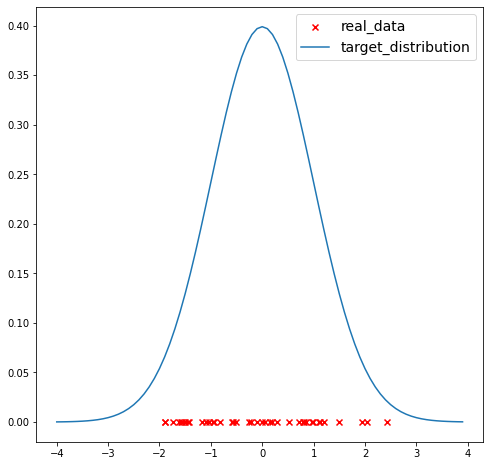

In [5]:
np.random.shuffle(p_data)
batch_size = 40
plt.figure(figsize=(8,8))
plt.scatter(p_data[0:batch_size], np.zeros(batch_size), c='red', marker="x", label="real_data")
x = np.arange(-4,4,0.1)
plt.plot(x, gauss(x, mu, var), label="target_distribution")
plt.legend(prop={'size':14})

In [6]:
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

In [7]:
#Settings 

M = 64
DEVICE = "cpu"
LR = 0.001
EPOCHS = 20

In [8]:
pdata_x = torch.tensor(p_data,dtype=torch.float, device=DEVICE)

In [9]:
pdata_y = torch.ones_like(pdata_x, device=DEVICE)

In [10]:
dataset = data.TensorDataset(pdata_x, pdata_y)
dataloader = data.DataLoader(dataset, batch_size=M, shuffle=False)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,11)
        self.fc2 = nn.Linear(11,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,11)
        self.fc2 = nn.Linear(11,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [13]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

In [14]:
optimG = optim.SGD(G.parameters(), lr=LR)
optimD = optim.SGD(D.parameters(), lr=LR)

In [15]:
G_losses, D_losses = [], []

In [16]:
G(torch.tensor([4.0]))

tensor([1.5237], grad_fn=<ReluBackward0>)

In [17]:
D(torch.tensor([2.0]))

tensor([0.7024], grad_fn=<SigmoidBackward0>)

In [18]:
loss_fn = nn.BCELoss()

In [19]:
fake_label = torch.zeros(M,dtype=torch.float)
real_label = torch.ones(M,dtype=torch.float)

In [20]:
G_losses, D_losses = [], []

In [21]:
for epoch in range(EPOCHS):
    for batch, (X, _) in enumerate(dataloader):
        
        D.zero_grad()
        
        output = D(X.unsqueeze(dim=1))
        errD_real = loss_fn(output.squeeze(), real_label)
        errD_real.backward()
        
        z = np.random.random(M)
        z = torch.tensor(z, dtype=torch.float)
        fake = G(z.unsqueeze(dim=1))
        
        output = D(fake.detach())
        
        errD_fake = loss_fn(output.squeeze(), fake_label)
        
        errD_fake.backward()
        
        
        errD = errD_fake + errD_real
        
        optimD.step()
        
        G.zero_grad()
        output = D(fake)
        errG = loss_fn(output.squeeze(), real_label)
        errG.backward()
        optimG.step()    
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

In [22]:
D(pdata_x.unsqueeze(dim=1)).mean()

tensor(0.7853, grad_fn=<MeanBackward0>)

In [23]:
z = torch.tensor(np.linspace(-5,5,M)+np.random.random(M)*.01, dtype=torch.float)

In [24]:
D(G(z.unsqueeze(dim=1)))

tensor([[0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2172],
        [0.2274],
        [0.2374],
        [0.2481],
        [0.2595],
        [0.2489],
        [0.2283],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0.2110],
        [0

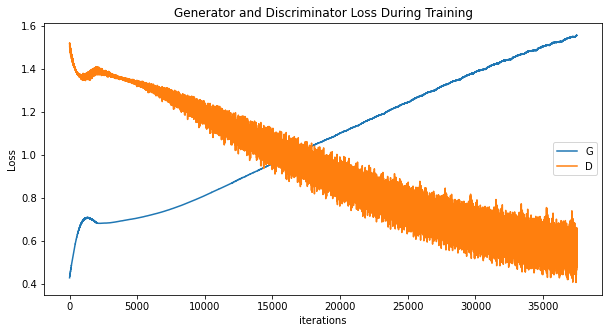

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[0.30699933 0.81811676 0.61095247 ... 0.57787814 0.48573135 0.18189007]


(array([    0.,     0.,     0.,     0.,     0., 16384.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

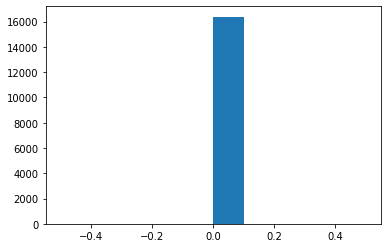

In [26]:
Z = np.array([random.random() for x in range (16384)])
print(Z)
samples = G(torch.tensor(Z, dtype=torch.float).unsqueeze(dim=1)).flatten()
plt.hist(samples.detach())